### Imports

In [1]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
from imblearn.over_sampling import SMOTE
from zipfile import ZipFile

#Stats Imports
from scipy import stats

import wrangle

### Certain configs

In [2]:
import matplotlib.style as style
style.use('seaborn-colorblind')

np.random.seed(123)

/var/folders/h6/xxqcvddd61v8kq3bhvkfyqzw0000gn/T/ipykernel_6061/692522295.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


### Acquire datasets

In [3]:
test, df = wrangle.acquire_fraud('cc_fraud.zip')

In [4]:
test.shape,df.shape

((555719, 23), (1296675, 23))

### Clean and Prep

In [5]:
df = wrangle.prep(df)
test = wrangle.prep(test)

In [6]:
df.head()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,28654,3495,"Psychologist, counselling",36.011293,-82.048315,0,30,Tuesday,0,Young_Adult
2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,99160,149,Special educational needs teacher,49.159047,-118.186462,0,40,Tuesday,0,Adult
2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,83252,4154,Nature conservation officer,43.150704,-112.154481,0,56,Tuesday,0,Mid_Age
2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,59632,1939,Patent attorney,47.034331,-112.561071,0,52,Tuesday,0,Early_Mid_Age
2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,24433,99,Dance movement psychotherapist,38.674999,-78.632459,0,32,Tuesday,0,Young_Adult


### Define target ('is_fraud') versus the rest of the features

In [7]:
target,features = wrangle.get_target_and_features(df)
print(target)
print('______')
print(features)

is_fraud
______
['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'job', 'merch_lat', 'merch_long', 'age', 'dayofweek', 'hourofday', 'age_group']


### Split the training data further (into Train and Validate)

In [8]:
x_train,x_validate,y_train,y_validate = wrangle.train_val(df)

In [9]:
x_train.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2019-10-23 19:14:39,fraud_Volkman PLC,food_dining,57.2,M,17850,645,Orthoptist,40.474056,-76.420734,45,Wednesday,19,Early_Mid_Age


In [10]:
y_train.sample()

trans_date_trans_time
2019-10-14 08:33:29    0
Name: is_fraud, dtype: int64

### Break the TEST dataset into x and y sets

In [11]:
x_test,y_test = wrangle.test_df_x_y_split(test)

In [12]:
x_test.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,
2020-11-20 12:01:14,fraud_Medhurst PLC,shopping_net,6.65,F,92561,1661,"Therapist, music",33.074625,-117.002407,32,Friday,12,Young_Adult


In [13]:
y_test.sample()

trans_date_trans_time
2020-07-14 21:08:01    0
Name: is_fraud, dtype: int64

# Begin EDA (using the original DF, which includes train and validate data)

In [14]:
# df.isna().sum()
# There are NO nulls

In [15]:
# df.info()

### First of all...CLASS IMBALANCE?

In [16]:
df.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

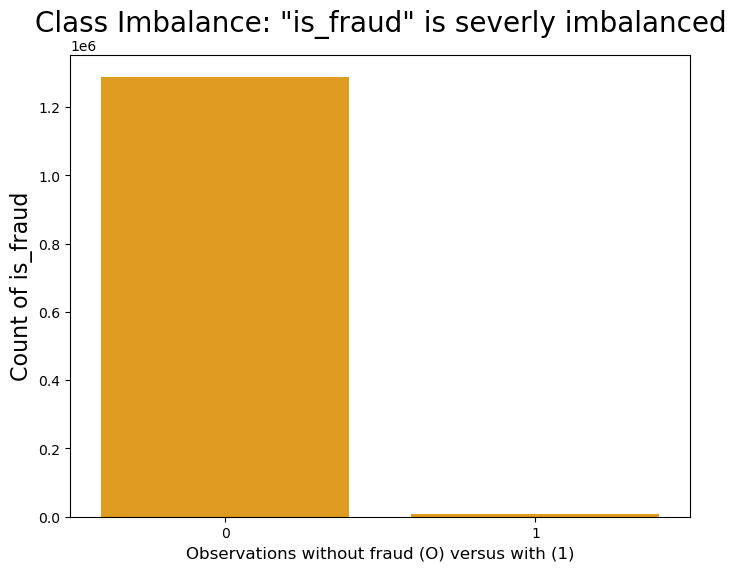

In [17]:
plt.figure(figsize = (8, 6))
ax = sns.countplot(x=df['is_fraud'],color='orange')
ax.set_xlabel(xlabel = 'Observations without fraud (O) versus with (1)', fontsize = 12)
ax.set_ylabel(ylabel = 'Count of is_fraud', fontsize = 16)
ax.set_title(label = 'Class Imbalance: "is_fraud" is severly imbalanced', fontsize = 20)

plt.show()

### Amount?

In [18]:
amount_df = df.copy()
amount_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2019-08-09 06:21:06,fraud_Huels-Hahn,gas_transport,50.26,F,12910,2148,"Surveyor, land/geomatics",45.215316,-72.742253,0,66,Friday,6,Retirement_Age


In [19]:
amount_df.amt.min(),amount_df.amt.max()

(1.0, 28948.9)

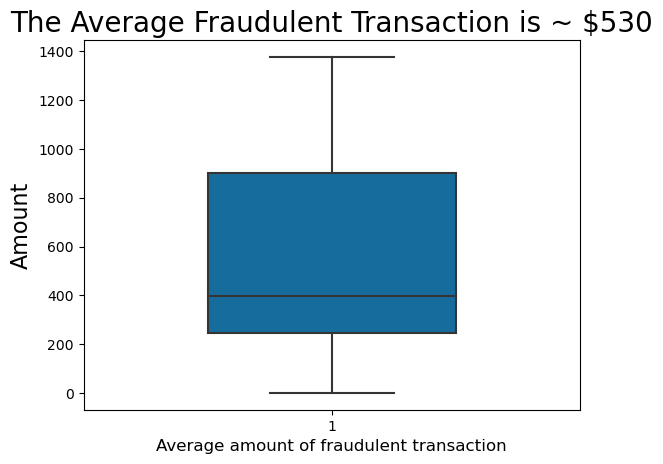

In [20]:
ax = sns.boxplot(data=amount_df[amount_df['is_fraud']==1],y=amount_df[amount_df['is_fraud']==1].amt,x=amount_df[amount_df['is_fraud']==1].is_fraud,width=.5)
ax.set_xlabel(xlabel = 'Average amount of fraudulent transaction', fontsize = 12)
ax.set_ylabel(ylabel = 'Amount', fontsize = 16)
ax.set_title(label = 'The Average Fraudulent Transaction is ~ $530', fontsize = 20)
plt.show()

In [21]:
df[df['is_fraud']==1].amt.min(),df[df['is_fraud']==1].amt.max(),df[df['is_fraud']==1].amt.mean()

(1.06, 1376.04, 531.3200919264589)

In [22]:
np.arange(0,1200,50)

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150])

In [23]:
bins = [   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150,35000]

In [24]:
labels = ['0_50','50_100','100_150','150_200','200_250','250_300','300_350','350_400','400_450','450_500','500_550','550_600','600_650','650_700','700_750','750_800','800_850','850_900','900_950','950_1000','1000_1050','1050_1100','1100_1150','over_1150']

In [25]:
# df['age_group'] = pd.cut(df['age'],[0,25,35,45,55,65,75,100], labels= ['Youth','Young_Adult','Adult','Early_Mid_Age','Mid_Age','Retirement_Age','Older_Person'],right=False)

amount_df['amt_bin'] = pd.cut(amount_df['amt'],bins=bins,labels=labels, right = False)
amount_df.sample(2)

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin
trans_date_trans_time,,,,,,,,,,,,,,,
2020-03-16 23:15:38,fraud_Heller PLC,health_fitness,29.75,M,94569,198,Armed forces training and education officer,38.821462,-122.627725,0,61,Monday,23,Mid_Age,0_50
2020-05-24 06:39:39,fraud_Nader-Heller,misc_net,381.65,F,97476,217,Retail merchandiser,43.514420,-123.588222,0,91,Sunday,6,Older_Person,350_400


In [26]:
amount_df[amount_df['is_fraud']==1].amt_bin.value_counts()

amt_bin
0_50         1607
300_350       974
250_300       701
900_950       487
950_1000      456
850_900       450
750_800       411
800_850       381
1000_1050     364
1050_1100     282
700_750       252
350_400       186
1100_1150     165
100_150       145
over_1150     139
650_700       122
200_250        94
450_500        61
500_550        50
50_100         45
600_650        45
550_600        44
400_450        40
150_200         5
Name: count, dtype: int64

# Could there be a polynomial relationship in the amount bins?

### Check the # of observations for each "price" bin

In [27]:
# down_sample.amt.groupby([down_sample['amt_bin'],down_sample['is_fraud'],down_sample['amt_bin']]).size().unstack(0)
# down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)
amount_df.groupby([amount_df['amt_bin'],amount_df['is_fraud']]).size().unstack(0)

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,670607,389469,127584,45283,23377,7459,4346,3094,2670,3297,...,662,585,450,398,363,296,253,234,210,2290
1,1607,45,145,5,94,701,974,186,40,61,...,252,411,381,450,487,456,364,282,165,139


### Create % fraud for each bin. 
1. Create DFs for # of observations per bin (as above) and their sum
2. Divide to get % fraud
3. Create ratio_fraud df (which is the set where fruad == 1, i.e. the second row of the percentage_df)
4. Merge % fraud in bin to the original df (resulting in fraud_ratio_per_bin_df)

In [28]:
# bins_fraud_breakdown = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0)
# bins_fraud_sum = down_sample.groupby([down_sample['amt_bin'],down_sample['is_fraud']]).size().unstack(0).sum()
bins_fraud_breakdown = amount_df.groupby([amount_df['amt_bin'],amount_df['is_fraud']]).size().unstack(0)
bins_fraud_sum = amount_df.groupby([amount_df['amt_bin'],amount_df['is_fraud']]).size().unstack(0).sum()

In [29]:
percentage_df = bins_fraud_breakdown/bins_fraud_sum
percentage_df

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,0.997609,0.999884,0.998865,0.99989,0.995995,0.914093,0.816917,0.943293,0.98524,0.981834,...,0.724289,0.587349,0.541516,0.46934,0.427059,0.393617,0.410049,0.453488,0.56,0.942775
1,0.002391,0.000116,0.001135,0.00011,0.004005,0.085907,0.183083,0.056707,0.01476,0.018166,...,0.275711,0.412651,0.458484,0.53066,0.572941,0.606383,0.589951,0.546512,0.44,0.057225


In [30]:
ratio_fraud = percentage_df[percentage_df.index == 1]
ratio_fraud

amt_bin,0_50,50_100,100_150,150_200,200_250,250_300,300_350,350_400,400_450,450_500,...,700_750,750_800,800_850,850_900,900_950,950_1000,1000_1050,1050_1100,1100_1150,over_1150
is_fraud,,,,,,,,,,,,,,,,,,,,,
1,0.002391,0.000116,0.001135,0.00011,0.004005,0.085907,0.183083,0.056707,0.01476,0.018166,...,0.275711,0.412651,0.458484,0.53066,0.572941,0.606383,0.589951,0.546512,0.44,0.057225


In [31]:
ratio_fraud = pd.DataFrame(ratio_fraud.unstack(0)).droplevel(1)
# temp_df

In [32]:
fraud_ratio_per_bin_df = amount_df.merge(ratio_fraud,on=['amt_bin']).rename(columns={0:'perc_fraud_in_bin'})

In [33]:
fraud_ratio_per_bin_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,amt_bin,perc_fraud_in_bin
370539,fraud_Ruecker Group,misc_net,14.42,M,1844,47249,Market researcher,41.922624,-71.873694,0,38,Friday,5,Adult,0_50,0.002391


In [34]:
amount_df.is_fraud.mean()

0.005788651743883394

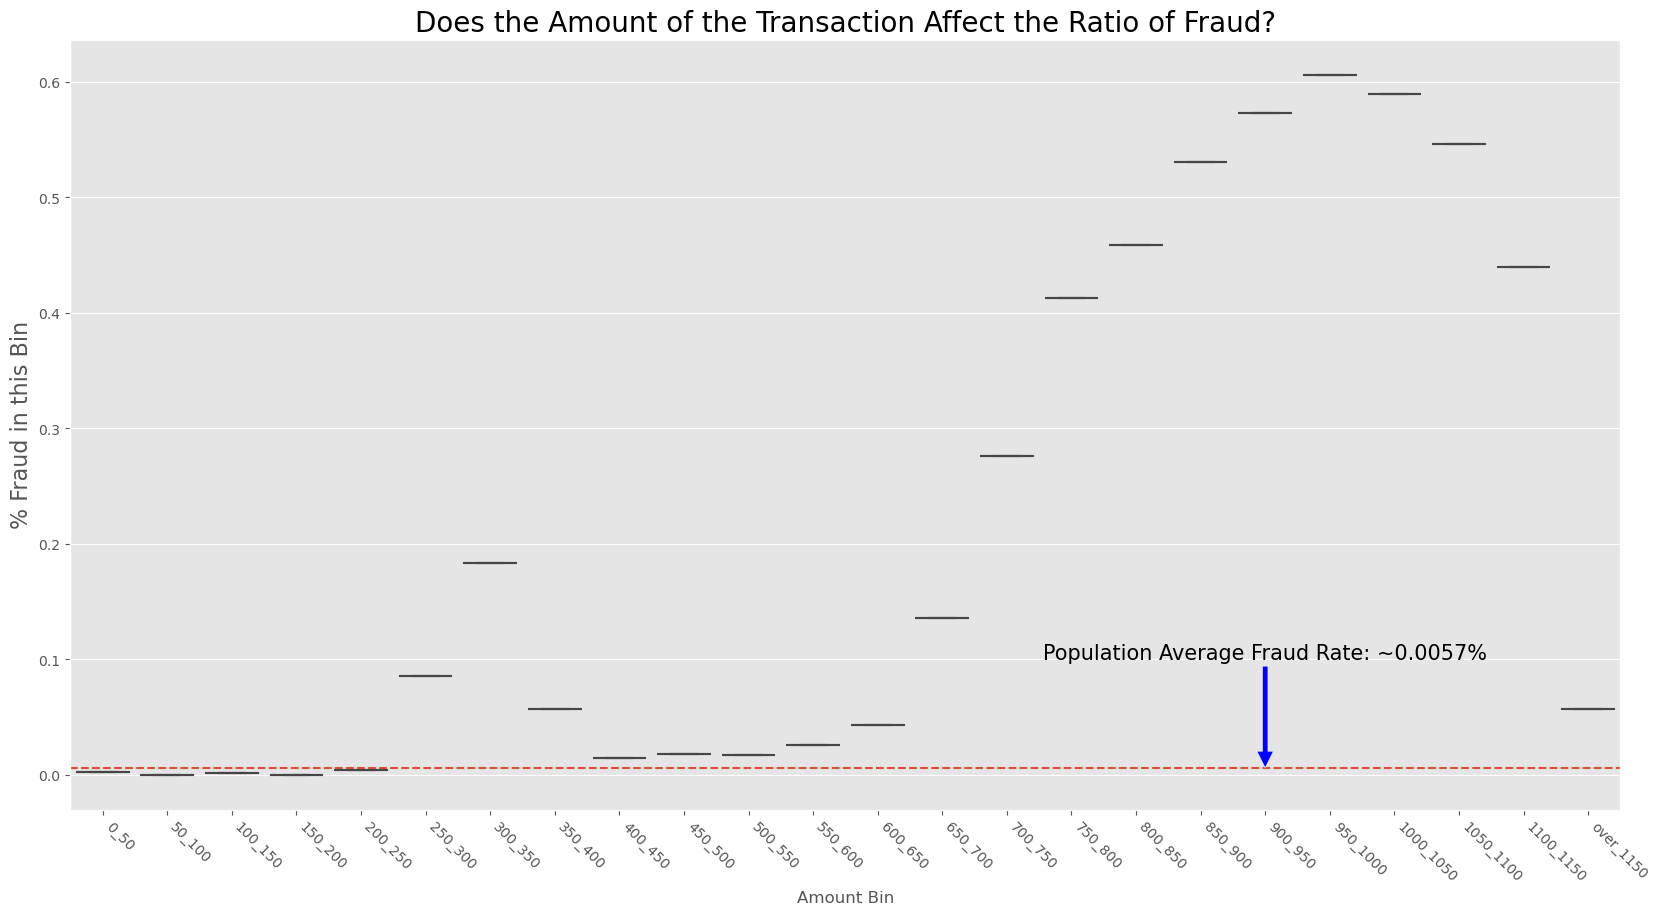

In [35]:
plt.figure(figsize = (20, 10))
plt.style.use('ggplot')
ax = sns.boxplot(data=fraud_ratio_per_bin_df,y=fraud_ratio_per_bin_df.perc_fraud_in_bin,x=fraud_ratio_per_bin_df.amt_bin)
ax.set_xlabel(xlabel = 'Amount Bin', fontsize = 12)
ax.set_ylabel(ylabel = '% Fraud in this Bin', fontsize = 16)
ax.set_title(label = 'Does the Amount of the Transaction Affect the Ratio of Fraud?', fontsize = 20)

ax.axhline(amount_df.is_fraud.mean(), ls='--')
plt.annotate('Population Average Fraud Rate: ~0.0057%', xy=(18, 0.006), xytext=(18,.1),arrowprops={'facecolor': 'blue'},size=15,ha='center')

plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
plt.show()

### Test the hypothesis that the amount has statistical significance. We will use the amount bins in lieu of the actual amounts (discrete vs continuous variables)

-- H0: The mean fraud rate of the different amount bins is equal

-- Ha: The mean fraud rate of the different amount bins is NOT equal

This will be a KRUSKAL Analysis of Variance
    
    * The assumptions of this test are met
    * The assumptions of the ANOVA test are not quite met, as the distributions are not parametric
        - These are large samples, but the Kruskal test was the better option--the result was the same either way

In [36]:
amount_df.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

In [37]:
dict_list=amount_df.amt_bin.unique().tolist()
# dict_list

In [38]:
df_0_50 = pd.DataFrame(amount_df[amount_df['amt_bin'] == '0_50'].is_fraud)
df_100_150 = pd.DataFrame(amount_df[amount_df['amt_bin'] == '100_150'].is_fraud)

In [39]:
names_list = []
for i in dict_list:#enumerate(dict_list):
    df_name = 'df_'+str(i)
#     print(df_name)
    names_list.append(df_name)

In [40]:
names_list

['df_0_50',
 'df_100_150',
 'df_200_250',
 'df_50_100',
 'df_150_200',
 'df_300_350',
 'df_600_650',
 'df_500_550',
 'df_1050_1100',
 'df_350_400',
 'df_450_500',
 'df_900_950',
 'df_over_1150',
 'df_400_450',
 'df_250_300',
 'df_1000_1050',
 'df_650_700',
 'df_750_800',
 'df_700_750',
 'df_800_850',
 'df_550_600',
 'df_850_900',
 'df_950_1000',
 'df_1100_1150']

In [41]:
d = {}
for x in amount_df.amt_bin.unique().tolist():
    d[x] = pd.DataFrame(amount_df[amount_df['amt_bin'] == x].is_fraud)

In [42]:
# for key, value in d.items():
#     print(f'The key is {key}', f'The value is {value}')

In [43]:
# for x in d:
#     print(d[x].var())
#The variances are all very small (under .3 in the highest case), so the diferrences are minor

In [44]:
alpha = .05
f,p = stats.kruskal(d['0_50'].is_fraud,
d['100_150'].is_fraud,
d['200_250'].is_fraud,
d['50_100'].is_fraud,
d['150_200'].is_fraud,
d['300_350'].is_fraud,
d['600_650'].is_fraud,
d['500_550'].is_fraud,
d['1050_1100'].is_fraud,
d['350_400'].is_fraud,
d['450_500'].is_fraud,
d['900_950'].is_fraud,
d['over_1150'].is_fraud,
d['400_450'].is_fraud,
d['250_300'].is_fraud,
d['1000_1050'].is_fraud,
d['650_700'].is_fraud,
d['750_800'].is_fraud,
d['700_750'].is_fraud,
d['800_850'].is_fraud,
d['550_600'].is_fraud,
d['850_900'].is_fraud,
d['950_1000'].is_fraud,
d['1100_1150'].is_fraud
)
f,p

(328361.19359891646, 0.0)

### The Kruskal test illustrates there is a statistically significant difference between the prevalence of fraud from one price bin to another

### Merchant

In [45]:
merchant_df = df.copy()

In [46]:
merchant_df.merchant.value_counts()

merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: count, Length: 693, dtype: int64

### Getting the min, max, and average fraud from all merchants

In [47]:
min(merchant_df.groupby(by='merchant').is_fraud.mean().sort_values()),max(merchant_df.groupby(by='merchant').is_fraud.mean().sort_values()),statistics.mean(merchant_df.groupby(by='merchant').is_fraud.mean().sort_values())

(0.0, 0.02572347266881029, 0.005602779328969938)

### The top 10 "offenders" for fraudulent transactions

In [48]:
merchant_df.groupby(by='merchant').is_fraud.mean().sort_values(ascending=False).head(10)

merchant
fraud_Kozey-Boehm                       0.025723
fraud_Herman, Treutel and Dickens       0.025385
fraud_Kerluke-Abshire                   0.022307
fraud_Brown PLC                         0.022109
fraud_Goyette Inc                       0.021616
fraud_Terry-Huel                        0.021543
fraud_Jast Ltd                          0.021505
fraud_Schmeler, Bashirian and Price     0.020833
fraud_Boyer-Reichert                    0.019916
fraud_Langworth, Boehm and Gulgowski    0.019807
Name: is_fraud, dtype: float64

## Category

### Getting the min, max, and average fraud from all merchants

In [49]:
min(merchant_df.groupby(by='category').is_fraud.mean().sort_values()),max(merchant_df.groupby(by='category').is_fraud.mean().sort_values()),statistics.mean(merchant_df.groupby(by='category').is_fraud.mean().sort_values())

(0.0015486905995645036, 0.017561485703740914, 0.005629390136310047)

### The top ten offending categories--the top 3 are respectively twice as high as the 4th

In [50]:
merchant_df.groupby(by='category').is_fraud.mean().sort_values(ascending=False).head(10)

category
shopping_net     0.017561
misc_net         0.014458
grocery_pos      0.014098
shopping_pos     0.007225
gas_transport    0.004694
misc_pos         0.003139
grocery_net      0.002948
travel           0.002864
entertainment    0.002478
personal_care    0.002424
Name: is_fraud, dtype: float64

## Gender

In [51]:
gender_df = df.copy()

### Like with the price bins above, we will add a column and graphically show the percentage of fraud by sex

In [52]:
gender_fraud_breakdown = gender_df.groupby([gender_df['gender'],gender_df['is_fraud']]).size().unstack(0)
gender_fraud_sum = gender_df.groupby([gender_df['gender'],gender_df['is_fraud']]).size().unstack(0).sum()

In [53]:
gender_percentage_df = gender_fraud_breakdown/gender_fraud_sum
# percentage_df

In [54]:
ratio_fraud_gender = gender_percentage_df[gender_percentage_df.index == 1]
ratio_fraud_gender

gender,F,M
is_fraud,,
1,0.005262,0.006426


In [55]:
ratio_fraud_gender = pd.DataFrame(ratio_fraud_gender.unstack(0)).droplevel(1)
# temp_df

In [56]:
gender_df = gender_df.merge(ratio_fraud_gender,on=['gender']).rename(columns={0:'perc_fraud_gender'})

In [57]:
gender_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,perc_fraud_gender
596730,fraud_Padberg-Rogahn,entertainment,17.34,F,40820,581,"Psychologist, counselling",37.416668,-83.435543,0,53,Sunday,13,Early_Mid_Age,0.005262


Text(0.5, 1.0, 'Do men commit more fraud than women?')

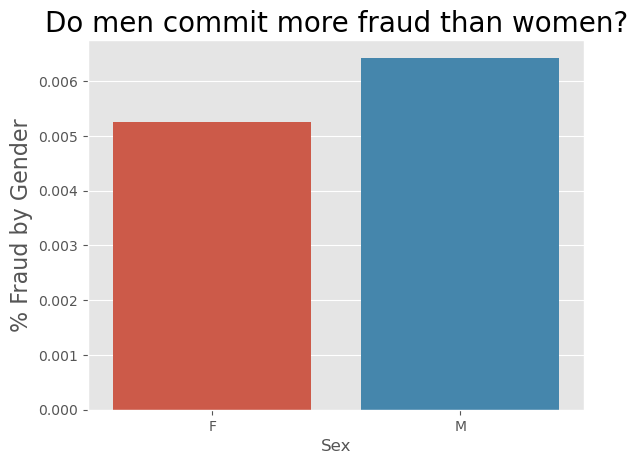

In [58]:
ax = sns.barplot(data=gender_df,y=gender_df.perc_fraud_gender,x=gender_df.gender)
plt.style.use('ggplot')
ax.set_xlabel(xlabel = 'Sex', fontsize = 12)
ax.set_ylabel(ylabel = '% Fraud by Gender', fontsize = 16)
ax.set_title(label = 'Do men commit more fraud than women?', fontsize = 20)

## The "male" transactions are slightly likelier to have fraud, according to this dataset.

### Let's test that with an chi^2 test

H0: Fraud is independent of someone's sex

Ha: One sex has more fraud associated

In [59]:
contingency_table = pd.crosstab(gender_df.gender,gender_df.is_fraud)
contingency_table

is_fraud,0,1
gender,,
F,706128,3735
M,583041,3771


In [60]:
chi2, p, deg_freedom, expected_matrix = stats.chi2_contingency(contingency_table)
chi2, p, deg_freedom

(75.51456622055794, 3.627211385830374e-18, 1)

In [61]:
expected_matrix

array([[705753.85030713,   4109.14969287],
       [583415.14969287,   3396.85030713]])

The p value is so low that we reject the null hypothesis

### Sex is a statistically significant driver of fraud

## Zip

In [62]:
zip_df = df.copy()

In [63]:
zip_df.zip.value_counts()

zip
73754    3646
34112    3613
48088    3597
82514    3527
49628    3123
         ... 
46510       7
16041       7
38915       7
10018       7
23523       7
Name: count, Length: 970, dtype: int64

In [64]:
min(zip_df.groupby(by='zip').is_fraud.mean().sort_values()),max(zip_df.groupby(by='zip').is_fraud.mean().sort_values()),statistics.mean(zip_df.groupby(by='zip').is_fraud.mean().sort_values())

(0.0, 1.0, 0.08191090570958835)

### There is a zip with all fraud?

In [65]:
# (df.groupby(by=['zip','is_fraud','city_pop']).is_fraud.mean() == 1)
pd.DataFrame(zip_df.groupby(by=['zip','city_pop']).is_fraud.mean().sort_values(ascending = False).head(73)).sort_values(by = 'city_pop')

,,is_fraud
zip,city_pop,
68375,121,1.0
54980,149,1.0
99747,239,1.0
67346,372,1.0
21657,777,1.0
...,...,...
89109,1417793,1.0
10018,1577385,1.0
78208,1595797,1.0


There are 73

In [66]:
all_fraud_zips = pd.DataFrame(zip_df.groupby(by=['zip','city_pop']).is_fraud.mean().sort_values(ascending = False).head(73)).sort_values(by = 'city_pop').rename(columns={'is_fraud':'all_transactions_fraud'})
all_fraud_zips.sample()

,,all_transactions_fraud
zip,city_pop,
47842,10085,1.0


In [67]:
zip_df = zip_df.merge(all_fraud_zips,how='outer',on='zip')
zip_df = zip_df.fillna({'all_transactions_fraud':0})
zip_df.sample()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group,all_transactions_fraud
383421,"fraud_Bernhard, Grant and Langworth",shopping_pos,3.51,F,50312,222785,Wellsite geologist,41.554281,-93.215154,0,63,Sunday,10,Mid_Age,0.0


In [68]:
# zip_df.groupby(by='zip').all_transactions_fraud.value_counts()
zip_df.where(zip_df.all_transactions_fraud==1).groupby(by='zip').all_transactions_fraud.count().sort_values(ascending = False)

zip
68375.0    19
99116.0    15
77038.0    15
11747.0    15
21657.0    13
           ..
95688.0     7
37411.0     7
61364.0     7
38915.0     7
77027.0     7
Name: all_transactions_fraud, Length: 73, dtype: int64

## Of all the 100% fraud zips, none of them have more than 19 transactions

### Population

In [69]:
pop_df = df.copy()

In [70]:
pd.DataFrame(pop_df.city_pop.value_counts())

,count
city_pop,
606,5496
1595797,5130
1312922,5075
1766,4574
241,4533
...,...
99475,7
198659,7
4046,7


In [71]:
# y_array = np.arange(pop_df.groupby(by='city_pop').is_fraud.mean().sort_values()
pd.DataFrame(pop_df.groupby(by='city_pop').is_fraud.mean().sort_values())

,is_fraud
city_pop,
3104,0.0
3766,0.0
3508,0.0
3495,0.0
3430,0.0
...,...
4299,1.0
1439,1.0
9141,1.0


There are cities with no fraud and cities with 100% fraud (refer to zip code EDA aboe)

In [72]:
pop_viz_df = pd.DataFrame(pop_df.city_pop.value_counts()).merge(pd.DataFrame(pop_df.groupby(by='city_pop').is_fraud.mean().sort_values()),left_index=True,right_index=True).rename(columns={'is_fraud':'fraud_percentage'})
pop_viz_df.head(1)

,count,fraud_percentage
city_pop,,
606,5496,0.002547


In [73]:
pop_viz_df.fraud_percentage = pop_viz_df.fraud_percentage.astype('float')

In [74]:
pop_viz_df[pop_viz_df.fraud_percentage==1].count()
# 57 cities have 100% fraud--meaning that some of the zip codes above span multiple cities

count               57
fraud_percentage    57
dtype: int64

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


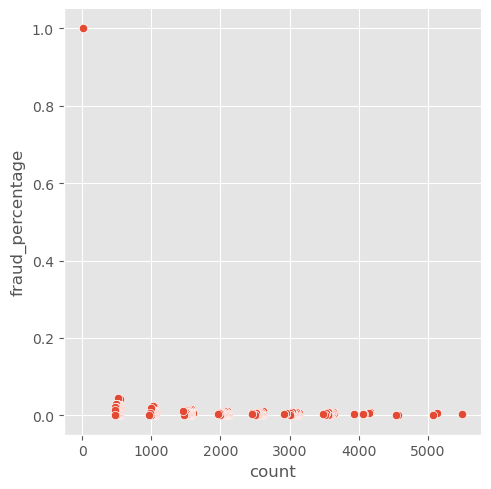

In [75]:
sns.relplot(data=pop_viz_df,x='count',y='fraud_percentage')


## Vizualized without any of the 100% fraud cities to better illustrate the general trend toward less fraud in larger cities

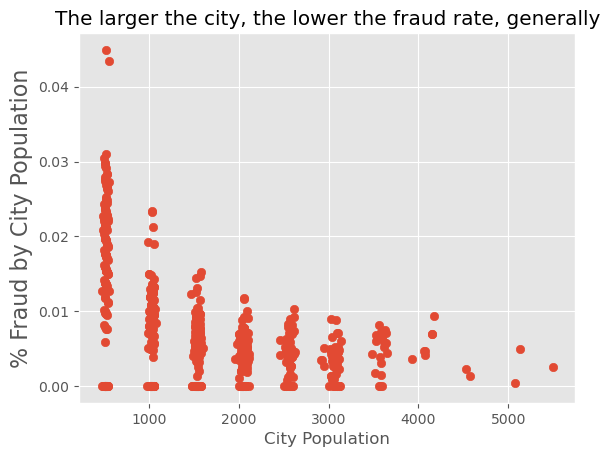

In [76]:
ax = plt.scatter(data=pop_viz_df[pop_viz_df.fraud_percentage!=1],x='count',y='fraud_percentage')
plt.style.use('ggplot')
plt.xlabel(xlabel = 'City Population')#, fontsize = 12)
plt.ylabel(ylabel = '% Fraud by City Population', fontsize = 16)
plt.title('The larger the city, the lower the fraud rate, generally')#, fontsize = 20)
plt.show()

### Unusual distribution of city populations

### Day? Hour? 

In [77]:
time_df = df.copy()

In [78]:
time_df.dayofweek.value_counts()

dayofweek
Monday       254282
Sunday       250579
Saturday     200957
Tuesday      160227
Friday       152272
Thursday     147285
Wednesday    131073
Name: count, dtype: int64

### Mon, Sun, and Sat are the days with the hightest number of fraudulent transactions

In [79]:
day_viz_df = pd.DataFrame(time_df.dayofweek.value_counts()).merge(pd.DataFrame(time_df.groupby(by='dayofweek').is_fraud.mean().sort_values()),left_index=True,right_index=True).rename(columns={'is_fraud':'fraud_percentage'}).reset_index()
day_viz_df

,dayofweek,count,fraud_percentage
0,Monday,254282,0.004648
1,Sunday,250579,0.004853
2,Saturday,200957,0.006106
3,Tuesday,160227,0.005835
4,Friday,152272,0.007086
5,Thursday,147285,0.006844
6,Wednesday,131073,0.006554


In [80]:
day_viz_df=day_viz_df.drop(columns=['count'])

<Axes: xlabel='dayofweek', ylabel='fraud_percentage'>

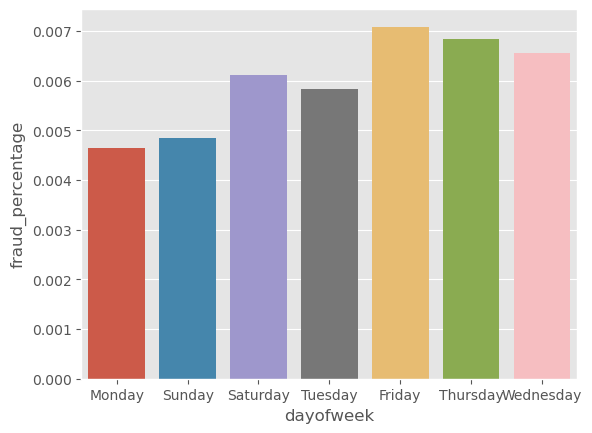

In [81]:
sns.barplot(data=day_viz_df,x=day_viz_df.dayofweek,y=day_viz_df.fraud_percentage)

### However, Fri, Thur and Wed have the highest percentage of fraudulent transactions

### Hour

In [82]:
time_df.hourofday.value_counts()

hourofday
23    67104
22    66982
18    66051
16    65726
21    65533
19    65508
17    65450
15    65391
13    65314
12    65257
20    65098
14    64885
1     42869
3     42769
2     42656
8     42505
0     42502
6     42300
10    42271
7     42203
9     42185
5     42171
11    42082
4     41863
Name: count, dtype: int64

### Afternoon and evening have a higher number of fraudulent transactions

In [83]:
hour_viz_df = pd.DataFrame(time_df.hourofday.value_counts()).merge(pd.DataFrame(time_df.groupby(by='hourofday').is_fraud.mean().sort_values()),left_index=True,right_index=True).rename(columns={'is_fraud':'fraud_percentage'}).drop(columns=['count']).reset_index()
hour_viz_df


,hourofday,fraud_percentage
0,23,0.028374
1,22,0.028829
2,18,0.001226
3,16,0.001156
4,21,0.001129
5,19,0.001236
6,17,0.001192
7,15,0.001208
8,13,0.001225
9,12,0.001027


<Axes: xlabel='hourofday', ylabel='fraud_percentage'>

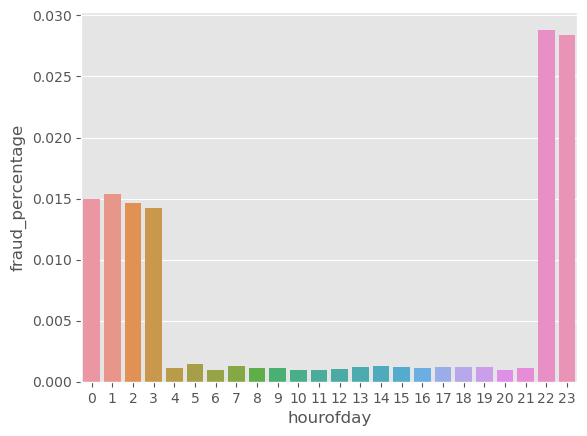

In [84]:
sns.barplot(data=hour_viz_df,x=hour_viz_df.hourofday,y=hour_viz_df.fraud_percentage)

### 10:00 and 11:00 are by far the highest percentage fraud hours, with the middle of the night being another popular fraud time

# Multivariate EDA?

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


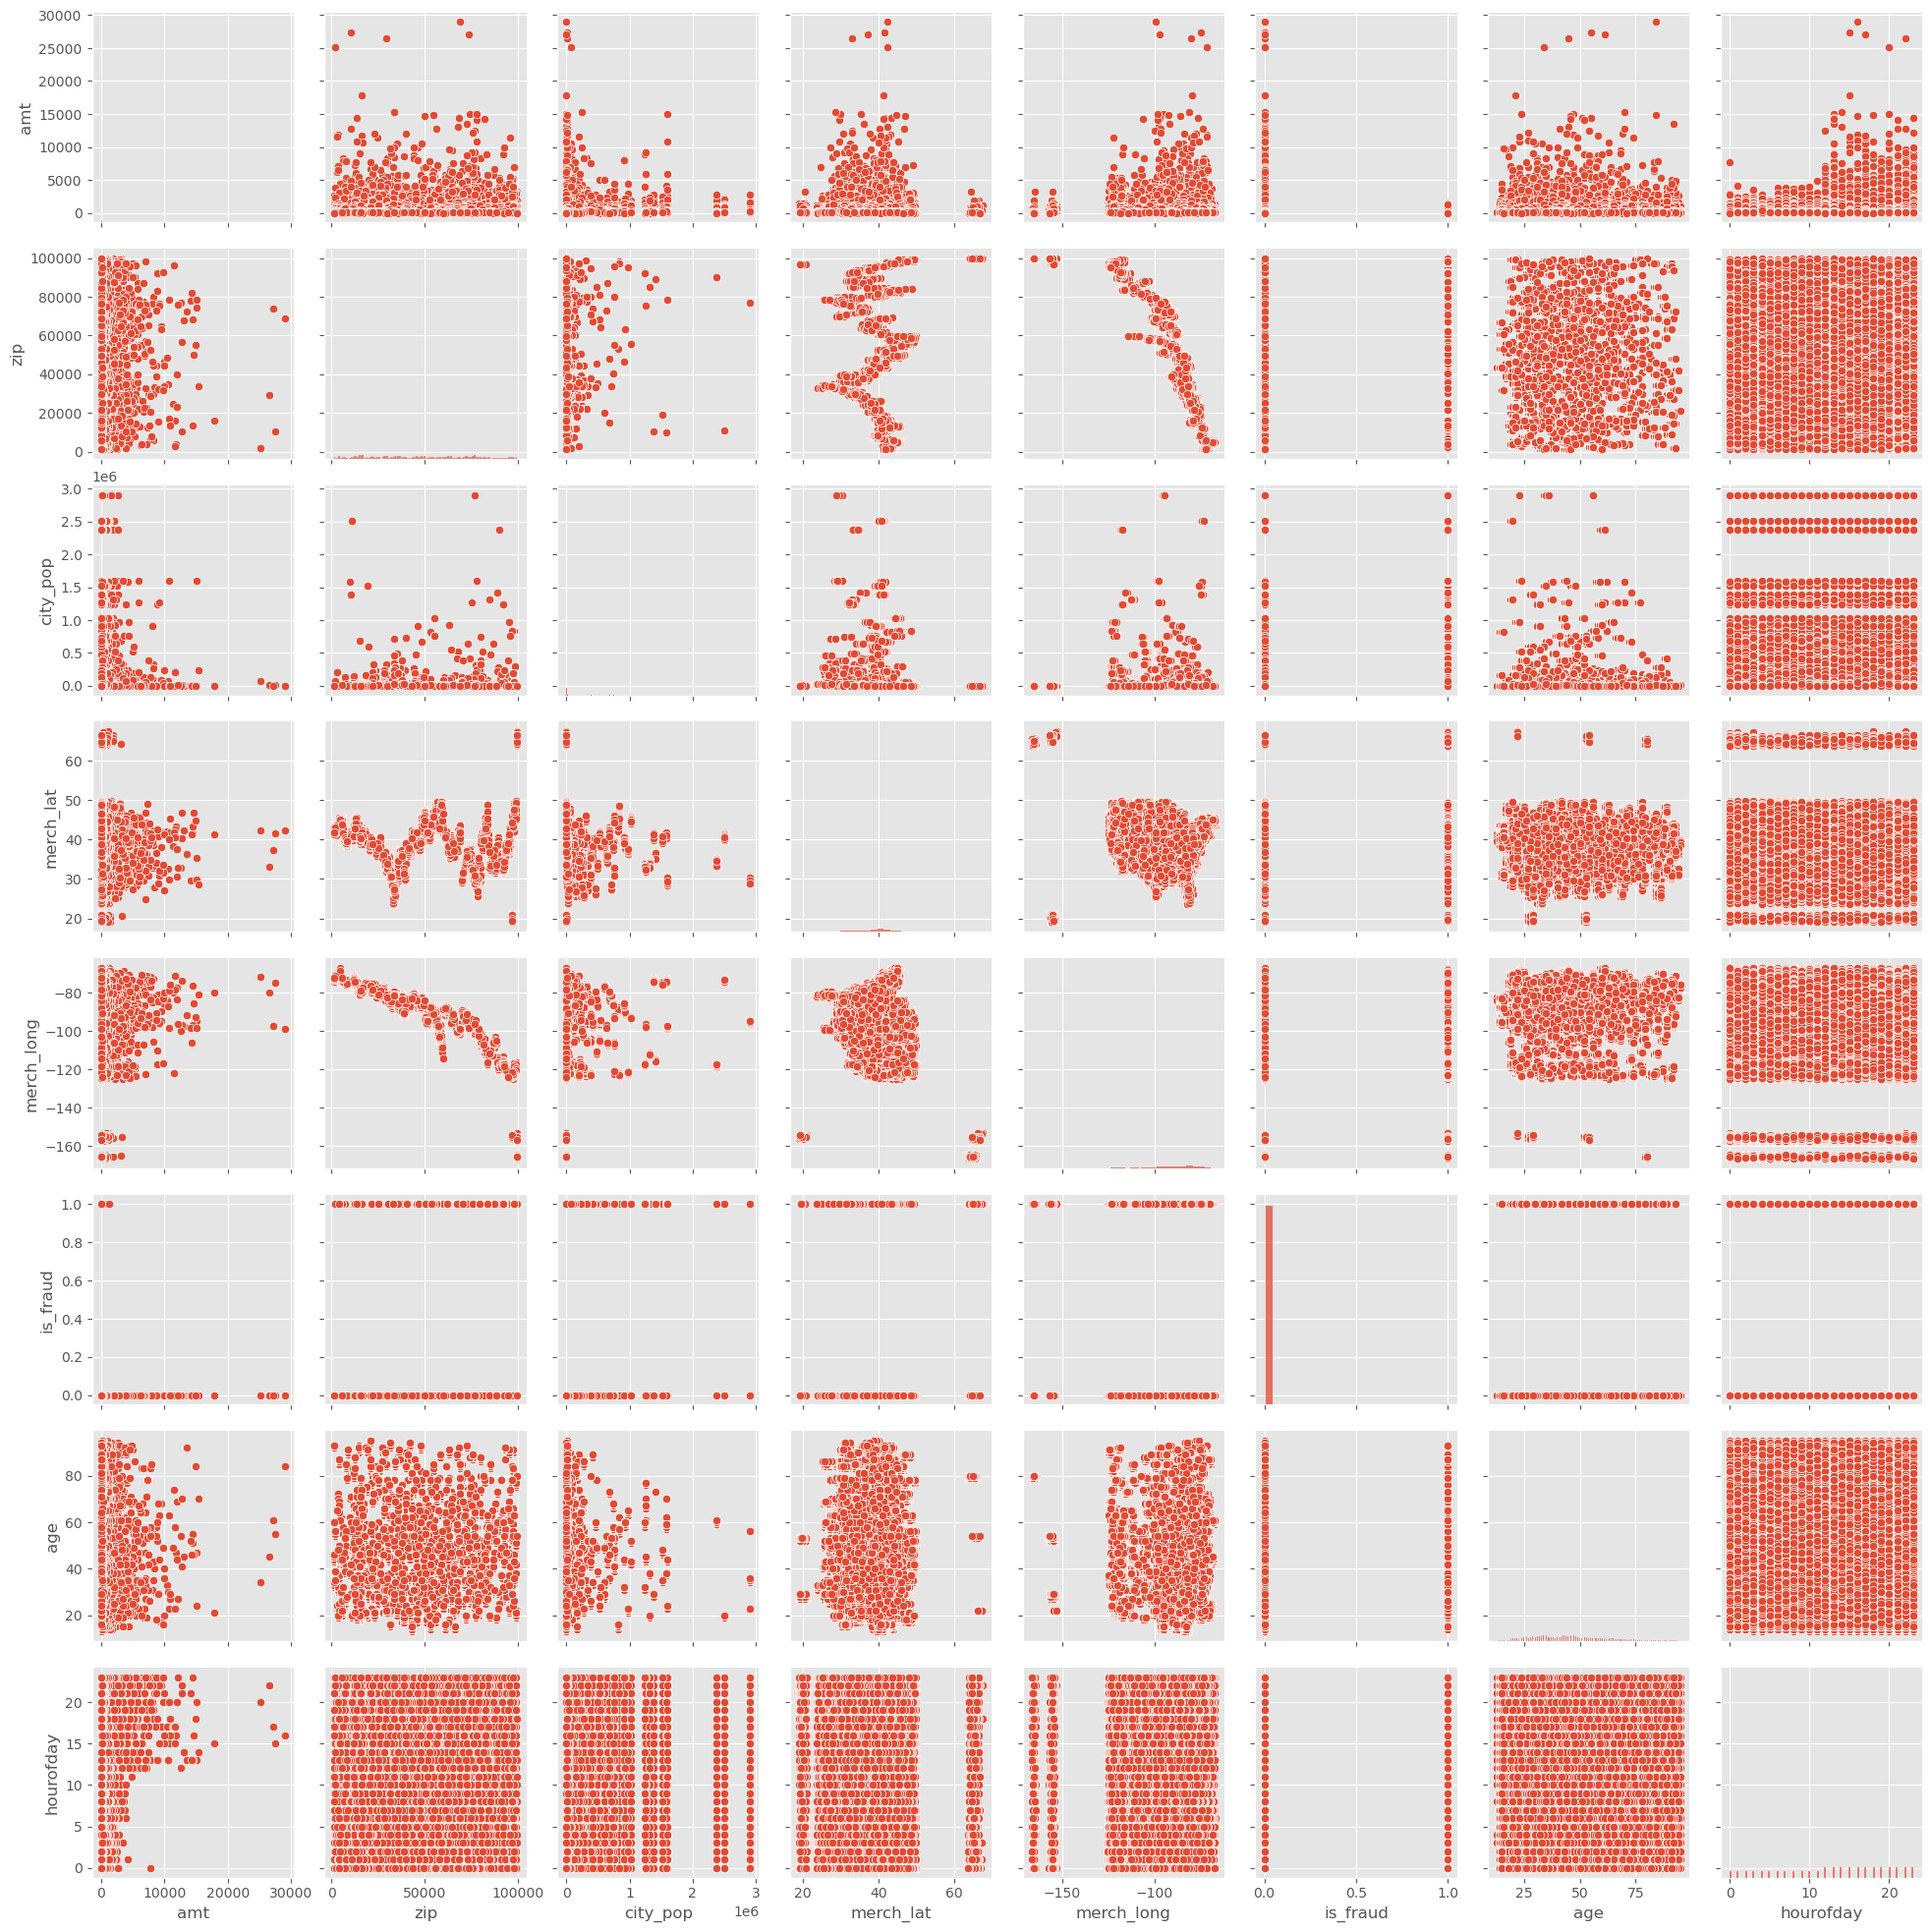

In [85]:
sns.pairplot(df)#,hue='gender') hueing this takes far too long to calculate

In [86]:
df.head()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
trans_date_trans_time,,,,,,,,,,,,,,
2019-01-01 00:00:18,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,28654,3495,"Psychologist, counselling",36.011293,-82.048315,0,30,Tuesday,0,Young_Adult
2019-01-01 00:00:44,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,99160,149,Special educational needs teacher,49.159047,-118.186462,0,40,Tuesday,0,Adult
2019-01-01 00:00:51,fraud_Lind-Buckridge,entertainment,220.11,M,83252,4154,Nature conservation officer,43.150704,-112.154481,0,56,Tuesday,0,Mid_Age
2019-01-01 00:01:16,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,59632,1939,Patent attorney,47.034331,-112.561071,0,52,Tuesday,0,Early_Mid_Age
2019-01-01 00:03:06,fraud_Keeling-Crist,misc_pos,41.96,M,24433,99,Dance movement psychotherapist,38.674999,-78.632459,0,32,Tuesday,0,Young_Adult


In [98]:
df.merchant.value_counts()

merchant
fraud_Kilback LLC                       4403
fraud_Cormier LLC                       3649
fraud_Schumm PLC                        3634
fraud_Kuhn LLC                          3510
fraud_Boyer PLC                         3493
                                        ... 
fraud_Douglas, DuBuque and McKenzie      775
fraud_Treutel-King                       775
fraud_Medhurst, Labadie and Gottlieb     759
fraud_Reichert-Weissnat                  753
fraud_Hahn, Douglas and Schowalter       727
Name: count, Length: 693, dtype: int64

In [117]:
# df.groupby('merchant')['category'].value_counts().loc[lambda x: x>1]

# df[df.merchant == 'fraud_Abbott-Rogahn']['category'].value_counts()

# counts = 
# df.groupby(['merchant','category']).count()
# counts[counts>=2]

cat_test = df.astype({'merchant':'category','category':'category'})
cat_test.groupby(['merchant','category']).value_counts()

ValueError: Product space too large to allocate arrays!

In [94]:
# business_category_count = 
# df.groupby(by=['merchant','category']).count()

# business_category_count[business_category_count>1]


# >>> customers = pd.DataFrame({'Email':['foo','bar','foo','foo','baz','bar'],
#                               'CustomerID':[1,2,1,2,1,1]})
# >>> email_cnt = customers.groupby('Email')['CustomerID'].size()
# >>> email_cnt[email_cnt > 1]

,,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud,age,dayofweek,hourofday,age_group
merchant,category,,,,,,,,,,,,
fraud_Abbott-Rogahn,entertainment,1844,1844,1844,1844,1844,1844,1844,1844,1844,1844,1844,1844
fraud_Abbott-Steuber,personal_care,1763,1763,1763,1763,1763,1763,1763,1763,1763,1763,1763,1763
fraud_Abernathy and Sons,food_dining,1751,1751,1751,1751,1751,1751,1751,1751,1751,1751,1751,1751
fraud_Abshire PLC,entertainment,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895
"fraud_Adams, Kovacek and Kuhlman",grocery_net,940,940,940,940,940,940,940,940,940,940,940,940
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fraud_Zemlak Group,misc_net,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297,1297
"fraud_Zemlak, Tillman and Cremin",personal_care,1804,1804,1804,1804,1804,1804,1804,1804,1804,1804,1804,1804
fraud_Ziemann-Waters,health_fitness,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695,1695
